In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import math
import pandas as pd

# Path to your Excel file
file_path = './UPDATED_NM student infractions 2010-2022.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Display the DataFrame
print(df)

                   District Name  District Code  \
0       ABQ SCHOOL OF EXCELLENCE            516   
1       ABQ SCHOOL OF EXCELLENCE            516   
2       ABQ SCHOOL OF EXCELLENCE            516   
3       ABQ SCHOOL OF EXCELLENCE            516   
4       ABQ SCHOOL OF EXCELLENCE            516   
...                          ...            ...   
285912                      ZUNI             89   
285913                      ZUNI             89   
285914                      ZUNI             89   
285915                      ZUNI             89   
285916                      ZUNI             89   

       Location Organization Type Code School Year Student Grade Level  \
0                              Charter  2014-06-30                   8   
1                              Charter  2014-06-30                   8   
2                              Charter  2014-06-30                   8   
3                              Charter  2014-06-30                   8   
4                

*PRIVACY MECHANISM*
Noising Entire Dataset (but assuming we are noising batches of data per year)
Varying Epsilon value per school, smaller school gets smaller epsilon

# Side Channel Test

In [ ]:
def get_flip_probability(k, epsilon):
    """
    Compute flip probability based on K-ary Randomized Response equation.

    Calculates the probability to flip to a value based on the K-ary Randomized Response equation:
    PRflip = 1 - e^epsilon / (e^epsilon + k - 1)

    Args:
        k (int): Number of values (alphabets/categories) in the distribution (column).
        epsilon (float): The privacy budget.

    Returns:
        float: The probability to flip to a value.
    """
    PRflip = 1 - math.e**epsilon / (math.e**epsilon + k - 1)
    return PRflip

def flip_value(x, X, epsilon):
    """
    Randomly flips the value of 'x' using K-ary randomized response mechanism.

    Uses K-ary randomized response mechanism to randomly replace the value of 'x' with another value 'y' selected from 'X'.

    Args:
        x: The input value to potentially flip.
        X: A list of other possible values to choose from.
        epsilon: The privacy budget.

    Returns:
        y: The flipped or unchanged value of 'x'.
    """
    # Generate a random number between 0 and 1
    random_number = random.random()
    # Generate probability to flip x
    k = len(X) # number of values (alphabets/categories) in the domain
    flip_probability = get_flip_probability(k, epsilon)
    # Check if we should flip the value
    if random_number <= flip_probability:
        # Flip the value by selecting a random value from known_values other than 'x'
        y = random.choice([value for value in X if value != x])
        return y
    else:
        # Keep the value x
        return x

def flip_value_SideChannel(x, X, epsilon):
    """
    Randomly flips the value of 'x' using K-ary randomized response mechanism.

    Uses K-ary randomized response mechanism to randomly replace the value of 'x' with another value 'y' selected from 'X'.

    Args:
        x: The input value to potentially flip.
        X: A list of other possible values to choose from.
        epsilon: The privacy budget.

    Returns:
        y: The flipped or unchanged value of 'x'.
    """
    # Generate a random number between 0 and 1
    random_number = random.random()
    # Generate probability to flip x
    k = len(X) # number of values (alphabets/categories) in the domain
    flip_probability = get_flip_probability(k, epsilon)
    # Check if we should flip the value
    if random_number <= flip_probability:
        # Flip the value by selecting a random value from known_values other than 'x'
        y = random.choice([value for value in X if value != x])
        return y
    else:
        y = random.choice([value for value in X if value != x]) # side channel prevention
        # Keep the value x
        return x

def noise_column(c_sr, X, epsilon):
    """
    Applies differential privacy to an entire column.

    Parameters:
        c_sr (pandas.Series): Pandas Series containing values from the column of interest.
        X (list): Possible values in the column.
        epsilon (float): Privacy budget for differential privacy. Lower values mean more privacy.

    Returns:
        list: List of privatized column values.
    """
    # Apply differential privacy to the list of c_sr
    c_private = map(lambda x: flip_value(x, X, epsilon), c_sr.tolist())
    c_private= list(c_private)
    return c_private

def noise_column_SideChannel(c_sr, X, epsilon):
    """
    Applies differential privacy to an entire column.

    Parameters:
        c_sr (pandas.Series): Pandas Series containing values from the column of interest.
        X (list): Possible values in the column.
        epsilon (float): Privacy budget for differential privacy. Lower values mean more privacy.

    Returns:
        list: List of privatized column values.
    """
    # Apply differential privacy to the list of c_sr
    c_private = map(lambda x: flip_value_SideChannel(x, X, epsilon), c_sr.tolist())
    c_private= list(c_private)
    return c_private

def get_epsilon(size, epsilon_config):
    """
    Get epsilon value depending on the number of entries in group/school.

    Parameters:
        size (int): Number of entries.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.

    Returns:
        float: Epsilon value.
    """
    default_epsilon = 1  # Default epsilon value
    epsilon = default_epsilon

    try:
        for config in epsilon_config:
            lower_bound, upper_bound, value = config
            if lower_bound <= size < upper_bound:
                epsilon = value
                #print("Epsilon found: ", epsilon)
                break
            if upper_bound == -1 and size >= lower_bound:
                epsilon = value
                #print("Epsilon found: ", epsilon)
                break
    except (TypeError, ValueError, IndexError):
        #print("Warning: Epsilon configuration is poorly formatted. Default epsilon value will be used.")
        epsilon = default_epsilon

    return epsilon

def generate_possible_values(df, columns_to_noise):
    """
    Creates a dictionary of column names and lists of their respective values from the entire dataset.
    Only for columns that need to be noised.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.

    Returns:
        dict: Dictionary of column names and lists of their respective values.
    """
    possible_values = {}

    try:
        # Iterate over columns
        for column in columns_to_noise:
            # Get unique values for the column
            possible_values[column] = df[column].unique().tolist()
    except KeyError as e:
        print(f"Error: Column '{e}' not found in the DataFrame.")

    return possible_values


def noise_dataframe(df, columns_to_noise, epsilon_config):
    """
    Apply noising for entire dataset by noising every school district with adapted epsilon value. Columns are noised independently.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.

    Returns:
        pandas.DataFrame: DataFrame with noised values.
    """
    df_noised = pd.DataFrame(columns=df.columns)  # Empty placeholder

    # Generate possible values per column of interest
    values_per_column = generate_possible_values(df, columns_to_noise)

    # Get names of schools/school districts
    school_names = df['District Name'].unique().tolist()

    # Noising every school
    for school in school_names:
        #print("*~*~*~*~* Running School:", school, "*~*~*~*~*")
        school_df = df[df['District Name'] == school].copy()

        # Get adaptive epsilon value
        school_case_numbers = len(school_df)
        curr_epsilon = get_epsilon(school_case_numbers, epsilon_config)

        for column in columns_to_noise:
            # Get unique values of column
            X = values_per_column[column]

            # Noise column
            noised_column = noise_column(school_df[column], X, curr_epsilon)
            school_df[column] = noised_column

        # Append noised school DataFrame to main noised DataFrame
        df_noised = pd.concat([df_noised, school_df], ignore_index=True)

    return df_noised

def noise_dataframe_SideChannel(df, columns_to_noise, epsilon_config):
    """
    Apply noising for entire dataset by noising every school district with adapted epsilon value. Columns are noised independently.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.

    Returns:
        pandas.DataFrame: DataFrame with noised values.
    """
    df_noised = pd.DataFrame(columns=df.columns)  # Empty placeholder

    # Generate possible values per column of interest
    values_per_column = generate_possible_values(df, columns_to_noise)

    # Get names of schools/school districts
    school_names = df['District Name'].unique().tolist()

    # Noising every school
    for school in school_names:
        #print("*~*~*~*~* Running School:", school, "*~*~*~*~*")
        school_df = df[df['District Name'] == school].copy()

        # Get adaptive epsilon value
        school_case_numbers = len(school_df)
        curr_epsilon = get_epsilon(school_case_numbers, epsilon_config)

        for column in columns_to_noise:
            # Get unique values of column
            X = values_per_column[column]

            # Noise column
            noised_column = noise_column_SideChannel(school_df[column], X, curr_epsilon)
            school_df[column] = noised_column

        # Append noised school DataFrame to main noised DataFrame
        df_noised = pd.concat([df_noised, school_df], ignore_index=True)

    return df_noised

In [ ]:
df50k = df.head(50000)
print(df50k)

                  District Name  District Code  \
0      ABQ SCHOOL OF EXCELLENCE            516   
1      ABQ SCHOOL OF EXCELLENCE            516   
2      ABQ SCHOOL OF EXCELLENCE            516   
3      ABQ SCHOOL OF EXCELLENCE            516   
4      ABQ SCHOOL OF EXCELLENCE            516   
...                         ...            ...   
49995               ALBUQUERQUE              1   
49996               ALBUQUERQUE              1   
49997               ALBUQUERQUE              1   
49998               ALBUQUERQUE              1   
49999               ALBUQUERQUE              1   

      Location Organization Type Code School Year Student Grade Level  \
0                             Charter  2014-06-30                   8   
1                             Charter  2014-06-30                   8   
2                             Charter  2014-06-30                   8   
3                             Charter  2014-06-30                   8   
4                             Char

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

df50k = df.head(50000)

columns_to_noise = ["Discipline Infraction","Student Race Ethnicity Derived",
                    "Drug Related","Alcohol Related","Gang Related","Hate Crime",
                    "Serious Injury","Criminal Charge Code","Repeat Offender","Immigrant",
                    "Gifted Participation Code","Student Grade Level","Student Gender Code"]

# Different epsilon configurations
epsilon_configs = [
    [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]], # config 1
    [[0, 100, 15.0], [101, 1000, 16.0], [1001, -1, 17.0]] # config 6
]

# Tracking runtime
runtimes_leak = [[],[]]
runtimes_secure = [[],[]]

# Apply noise function with different configurations and measure query time
for i, epsilon_config in enumerate(epsilon_configs):
  for run in range(50):  # Updated to 100 runs as initially described
        print("Run = ", run," ; Epsilon: ", epsilon_config)
        # Apply noise, with leak
        # start1 = timer()
        # noised_df = noise_dataframe(df50k, columns_to_noise, epsilon_config)
        # end1 = timer()
        # runtimes_leak[i].append(end1-start1)

        # Apply noise, withOUT leak
        start2 = timer()
        noised_df = noise_dataframe_SideChannel(df50k, columns_to_noise, epsilon_config)
        end2 = timer()
        runtimes_secure[i].append(end2-start2)

Run =  0  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  1  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  2  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  3  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  4  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  5  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  6  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  7  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  8  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  9  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  10  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  11  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  12  ; Epsilon:  [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]]
Run =  13  ; Epsilon:  [[0, 100, 0.2], [101, 100

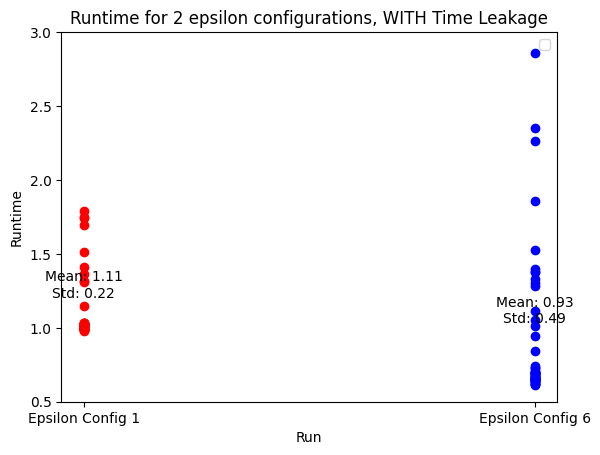

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generating y-axis values for dots distribution
y_values_run1 = np.arange(len(runtimes_leak[0]))
y_values_run2 = np.arange(len(runtimes_secure[0]))

# Plotting dot plot
plt.plot(["Epsilon Config 1"]*50, runtimes_leak[0], 'ro')  # Config 1, SD secure
plt.plot(["Epsilon Config 6"]*50, runtimes_leak[1], 'bo')  # Config 6, SD secure
plt.ylim(0.5, 3.0)  # Replace 0 and 100 with your desired minimum and maximum values
# Adding labels and title
plt.xlabel('Run')
plt.ylabel('Runtime')
plt.title('Runtime for 2 epsilon configurations, WITH Time Leakage')
plt.legend()

# Calculate mean and standard deviation
means = [np.mean(runtimes_leak[0]), np.mean(runtimes_leak[1])]
stds = [np.std(runtimes_leak[0]), np.std(runtimes_leak[1])]

# Annotate plot with mean and standard deviation
for i in range(2):
    plt.text(i, means[i] + 0.1, f'Mean: {means[i]:.2f}\nStd: {stds[i]:.2f}', horizontalalignment='center')

# Displaying the plot
plt.show()

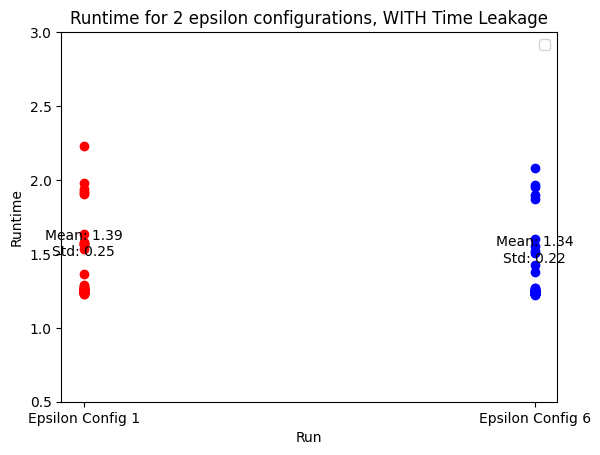

In [ ]:
# Plotting dot plot
plt.plot(["Epsilon Config 1"]*50, runtimes_secure[0], 'ro')  # Config 1, SD secure
plt.plot(["Epsilon Config 6"]*50, runtimes_secure[1], 'bo')  # Config 6, SD secure
plt.ylim(0.5, 3.0)  # Replace 0 and 100 with your desired minimum and maximum values
# Adding labels and title
plt.xlabel('Run')
plt.ylabel('Runtime')
plt.title('Runtime for 2 epsilon configurations, WITH Time Leakage')
plt.legend()

# Calculate mean and standard deviation
means = [np.mean(runtimes_secure[0]), np.mean(runtimes_secure[1])]
stds = [np.std(runtimes_secure[0]), np.std(runtimes_secure[1])]

# Annotate plot with mean and standard deviation
for i in range(2):
    plt.text(i, means[i] + 0.1, f'Mean: {means[i]:.2f}\nStd: {stds[i]:.2f}', horizontalalignment='center')

# Displaying the plot
plt.show()